# **Pokémon Diffusion<a id="top"></a>**

> #### ``04-Training-Diffusion-Model.ipynb``

<i><small>**Alumno:** Alejandro Pequeño Lizcano<br>Última actualización: 20/05/2024</small></i></div>

TODO: INTRODUCIR MEJOR

Como paso final, se procede a entrenar el modelo de difusión. Para ello, se ha definido la función ``training()`` que engloba todo el proceso de difusión completo, tanto hacia adelante como hacia atrás y los ploteos de las muestras generadas. Para implementar el training hemos usado el **Algoritmo 1** de [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) y se ha modificado para que sea capaz de generar imágenes condicionadas a una etiqueta.

<div style="text-align:center">
<img src="../figures/notebook_figures/algorithm1_training.png" width="40%" height="30%" />
</div>

También se han añadido unas funcionalidades extra que permiten guardar cada epoch el modelo y sus pesos en un fichero con extensión .h5. Esto se hace para poder cargar el modelo y continuar el entrenamiento desde donde se quedó en caso de que se interrumpa por algún motivo.

><span style="color: red; font-size: 1.5em;">&#9888;</span> <i><small>**NOTA:** Por cada epoch se guarda en un fichero con extensión .h5 tanto el modelo como sus pesos. Este proceso se realiza ya que todo el entrenamiento es muy costoso y si se interrumpe por algún motivo, se puede volver a cargar el modelo y continuar el entrenamiento desde donde se quedó.
>
>También cabe destacar que para una mayor eficiencia en el entrenamiento, se ha optado por realizar el ``sampling()`` cada 20 epochs.
</small></i>

# 0. Imports

In [37]:
# Import necessary libraries
# =====================================================================
import tensorflow as tf
import configparser
from src.model.build_model import build_unet
from src.utils import *
from src.utils.config import parse_config
from src.visualization import visualize
from src.model.diffusion_funcionality import *
from src.model.model_callbacks import *

In [38]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [39]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(CONFIG_PATH)

hyperparameters = parse_config(config, "hyperparameters")

IMG_SIZE = hyperparameters["img_size"]
NUM_CLASSES = hyperparameters["num_classes"]
BATCH_SIZE = hyperparameters["batch_size"]
EPOCHS = hyperparameters["epochs"]

TIMESTEPS = hyperparameters["timesteps"]
SCHEDULER = hyperparameters["scheduler"]
BETA_START = hyperparameters["beta_start"]
BETA_END = hyperparameters["beta_end"]
S = hyperparameters["s"]

# 1. Dataset

In [40]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset/size{IMG_SIZE}x{IMG_SIZE}_batch{BATCH_SIZE}"
poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

- The shape of the dataset is: (64, 32, 32, 3) => batch_size: 64, height: 32, width: 32, channels: 3
- The shape of the dataset labels is: (64, 18) => batch_size: 64, number of labels: 18


2024-06-10 21:01:58.266979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-06-10 21:01:58.434417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


- Train size: 3840 sprites
- Test size: 192 sprites


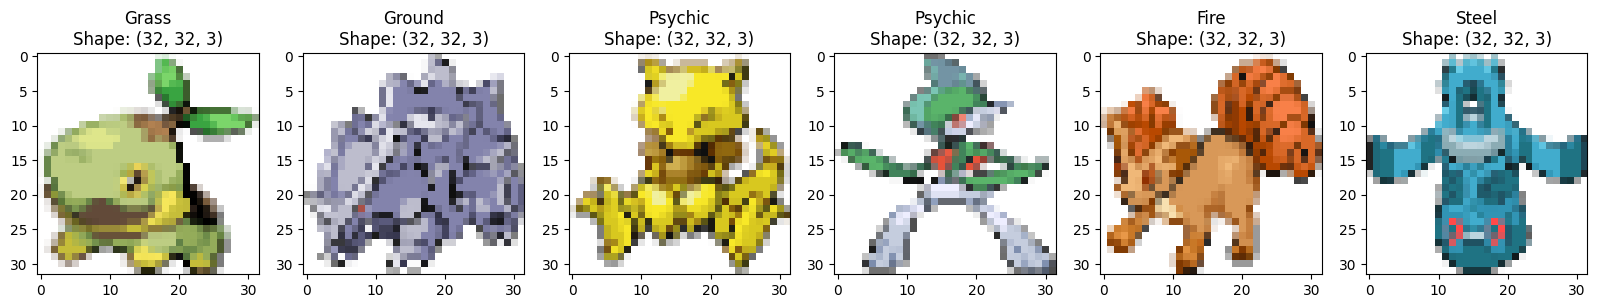

2024-06-10 21:01:58.742524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


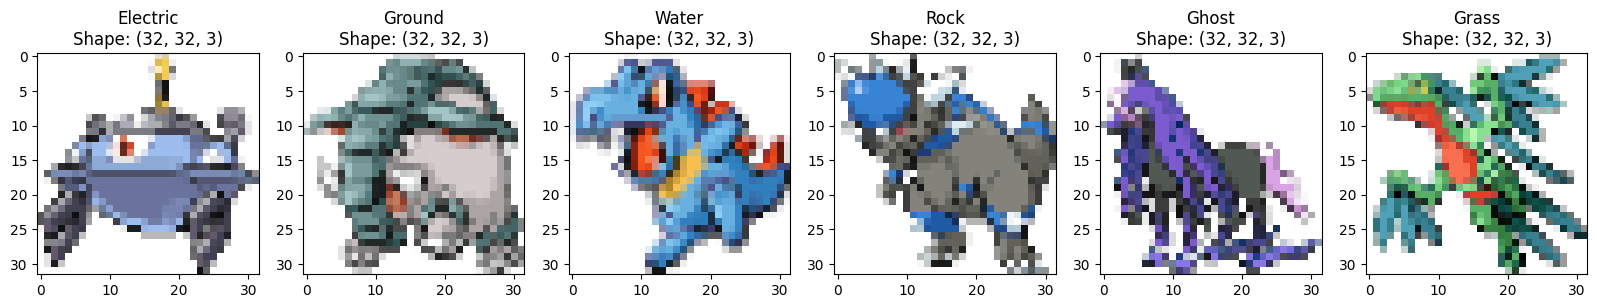

2024-06-10 21:01:59.011123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [41]:
# train test split
# =====================================================================
train_poke_dataset, test_poke_dataset = tf.keras.utils.split_dataset(
    poke_dataset, left_size=0.95, shuffle=True
)

# Length of the datasets
print(f"- Train size: {len(train_poke_dataset) * BATCH_SIZE} sprites")
print(f"- Test size: {len(test_poke_dataset) * BATCH_SIZE} sprites")

# Plot
visualize.plot_images_batch(train_poke_dataset, 6)
visualize.plot_images_batch(test_poke_dataset, 6)

In [ ]:
        # Randomly mask out input_label
        mask = tf.random.uniform(
            shape=(batch_size, self.num_classes), minval=0, maxval=1
        )

        mask = tf.cast(mask > 0.9, tf.float32)
        input_label = tf.cast(input_label, tf.float32)
        y = tf.cast(input_label * mask, tf.int32)

# 2. Model

In [6]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, TIMESTEPS, BETA_START, BETA_END, S, SCHEDULER
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer, metrics=["mae"])

## 2.1. Training

In [7]:
# Train the model
# =====================================================================
diff_callback = DiffusionCallback(model, 20, "Dragon")
history = model.fit(
    train_poke_dataset,
    epochs=EPOCHS,
    validation_data=test_poke_dataset,
    callbacks=[diff_callback],
)

Epoch 1/6


I0000 00:00:1718042860.807323   48206 service.cc:145] XLA service 0x7cf904003650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718042860.807344   48206 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-06-10 18:07:41.185182: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1718042861.678449   48206 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
2024-06-10 18:07:42.579617: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1718042863.579890   48626 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3', 16 bytes

 1/60 ━━━━━━━━━━━━━━━━━━━━ 35:46 36s/step - mae: 1.0779 - loss: 1.8386

I0000 00:00:1718042885.566030   48206 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 ━━━━━━━━━━━━━━━━━━━━ 45s 151ms/step - mae: 0.7965 - loss: 1.0519 - val_loss: 0.3975 - val_mae: 0.4782
Epoch 2/6
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.4429 - loss: 0.3523 - val_loss: 0.2705 - val_mae: 0.3789
Epoch 3/6
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.3635 - loss: 0.2535 - val_loss: 0.2211 - val_mae: 0.3328
Epoch 4/6
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.3376 - loss: 0.2295 - val_loss: 0.2126 - val_mae: 0.3186
Epoch 5/6
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - mae: 0.3145 - loss: 0.2038 - val_loss: 0.1861 - val_mae: 0.2974
Epoch 6/6
60/60 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - mae: 0.2960 - loss: 0.1846 - val_loss: 0.1899 - val_mae: 0.2942


## 2.2. Evaluation

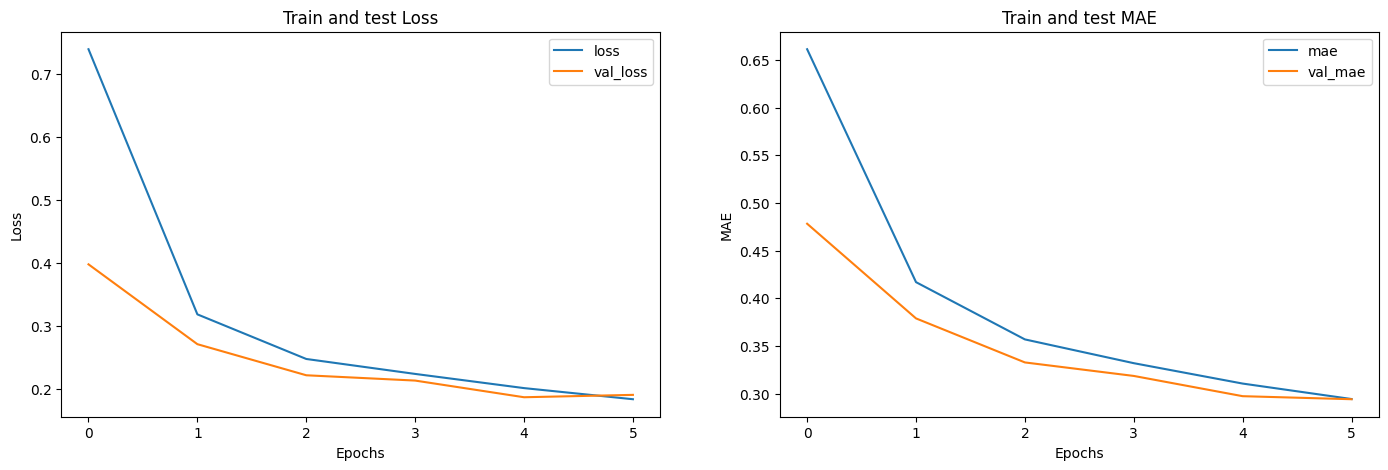

In [8]:
visualize.plot_history(history)

## 2.3. Results and save model

In [ ]:
# Save and load the model
# =====================================================================
save_path = f"{MODELS_PATH}/diffusion_{IMG_SIZE}x{IMG_SIZE}_batch{BATCH_SIZE}_epochs{EPOCHS}.weights.h5"
model.save_weights(save_path)

model_loaded = DiffusionModel.load_model(
    save_path,
    u_net,
    IMG_SIZE,
    NUM_CLASSES,
    TIMESTEPS,
    BETA_START,
    BETA_END,
    S,
    SCHEDULER,
)

In [ ]:
# Sample some sprites
# =====================================================================
model_loaded.plot_samples(6)
model_loaded.plot_samples(6)
model_loaded.plot_samples(6, "Fire")
model_loaded.plot_samples(6, "Water")
model_loaded.plot_samples(6, "Grass")
model_loaded.plot_samples(6, "Dragon")

[BACK TO TOP](#top)